# WORKFLOW FOR CONTROL DESIGN

This notebook is an executeable narrative control design. You should use this as a template for Homework 3, the completed closed loop design of your biological system.

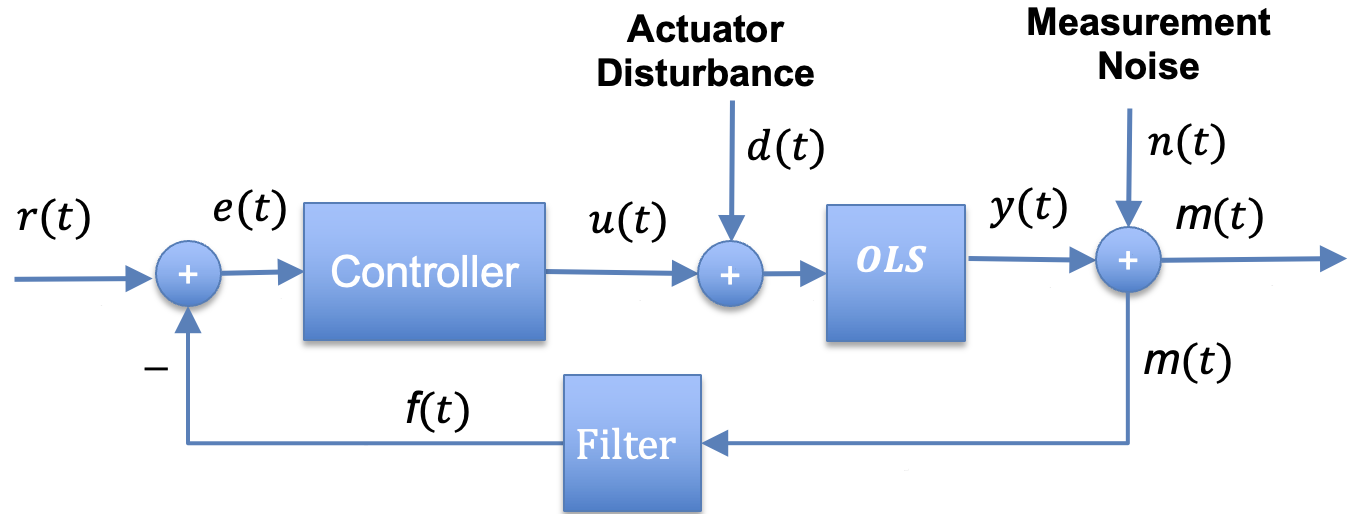

In [1]:
from IPython.display import Image
Image("closed_loop_system.png", width = 600, height = 300)

# Preliminaries

In [2]:
import collections
import control
import controlSBML as ctl
import lmfit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

# Models

## Linear

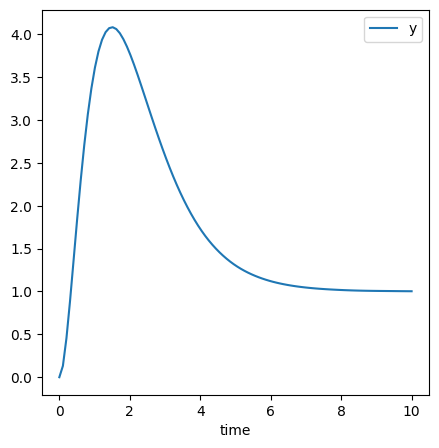

In [22]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
ctlsb = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S3"])
LINEAR_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="linear_sys")
_ = plotSys(LINEAR_BLDR.sys)

## Wolf

In [16]:
WOLF_MODEL = """
// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
  s2 = 5;
  s3 = 0.6;
  na = 0.6;
  s4 = 0.7;
  s5 = 8;
  s6 = 0.08;
  s6o = 0.02;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  k0 = 50;
  k0 has mM_min_1;
  k1 = 550;
  k1 has mM_1_min_1;
  k2 = 9.8;
  k2 has min_1;
  k31 = 323.8;
  k31 has mM_1_min_1;
  k33 = 57823.1;
  k33 has mM_1_min_1;
  k32 = 76411.1;
  k32 has mM_1_min_1;
  k34 = 23.7;
  k34 has mM_1_min_1;
  k4 = 80;
  k4 has mM_1_min_1;
  k5 = 9.7;
  k5 has min_1;
  k6 = 2000;
  k6 has mM_1_min_1;
  k7 = 28;
  k7 has min_1;
  k8 = 85.7;
  k8 has mM_1_min_1;
  k9 = 80;
  k9 has min_1;
  k10 = 375;
  k10 has min_1;
  atot = 4;
  atot has mM;
  ntot = 1;
  ntot has mM;
  n = 4;
  n has dimensionless;
  ki = 1;
  ki has mM;

  // Other declarations:
  const compartment_, k0, k1, k2, k31, k33, k32, k34, k4, k5, k6, k7, k8;
  const k9, k10, atot, ntot, n, ki;

  // Unit definitions:
  unit substance = 1e-3 mole;
  unit time_unit = 60 second;
  unit mM = 1e-3 mole / litre;
  unit mM_min_1 = 1e-3 mole / (litre * 60 second);
  unit min_1 = 1 / 60 second;
  unit mM_1_min_1 = litre / (1e-3 mole * 60 second);

  // Display Names:
  substance is "milli mole";
  time_unit is "min";
  compartment_ is "compartment";
  s1 is "Glucose";
  at_ is "ATP";
  s2 is "F16P";
  s3 is "Triose_Gly3Phos_DHAP";
  na is "NAD";
  s4 is "3PG";
  s5 is "Pyruvate";
  s6 is "Acetaldehyde";
  s6o is "extracellular acetaldehyde";

  // CV terms:
  s1 identity "http://identifiers.org/obo.chebi/CHEBI:17234",
              "http://identifiers.org/kegg.compound/C00293"
  at_ identity "http://identifiers.org/obo.chebi/CHEBI:15422",
               "http://identifiers.org/kegg.compound/C00002"
  s2 identity "http://identifiers.org/obo.chebi/CHEBI:16905",
              "http://identifiers.org/kegg.compound/C05378"
  s3 part "http://identifiers.org/obo.chebi/CHEBI:16108",
          "http://identifiers.org/obo.chebi/CHEBI:29052",
          "http://identifiers.org/kegg.compound/C00111",
          "http://identifiers.org/kegg.compound/C00118"
  na identity "http://identifiers.org/obo.chebi/CHEBI:15846",
              "http://identifiers.org/kegg.compound/C00003"
  s4 identity "http://identifiers.org/obo.chebi/CHEBI:17794",
              "http://identifiers.org/kegg.compound/C00197"
  s5 identity "http://identifiers.org/kegg.compound/C00022",
              "http://identifiers.org/chebi/CHEBI:32816"
  s5 identity "http://identifiers.org/obo.chebi/CHEBI:15361"
  s6 identity "http://identifiers.org/obo.chebi/CHEBI:15343",
              "http://identifiers.org/kegg.compound/C00084"
  s6o identity "http://identifiers.org/obo.chebi/CHEBI:15343",
               "http://identifiers.org/kegg.compound/C00084"
  v1 part "http://identifiers.org/kegg.reaction/R00756",
          "http://identifiers.org/kegg.reaction/R00299"
  v1 part "http://identifiers.org/ec-code/2.7.1.11",
          "http://identifiers.org/ec-code/5.3.1.9"
  v2 identity "http://identifiers.org/ec-code/4.1.2.13",
              "http://identifiers.org/kegg.reaction/R01070"
  v3 part "http://identifiers.org/ec-code/2.7.2.3",
          "http://identifiers.org/ec-code/1.2.1.12"
  v4 part "http://identifiers.org/kegg.reaction/R00658",
          "http://identifiers.org/kegg.reaction/R00200"
  v4 part "http://identifiers.org/ec-code/2.7.1.40"
  v5 hypernym "http://identifiers.org/ec-code/4.1.1.1",
              "http://identifiers.org/kegg.reaction/R00224"
  v7 hypernym "http://identifiers.org/obo.go/GO:0006754"
  v8 part "http://identifiers.org/kegg.reaction/R05679"
  v9 hypernym "http://identifiers.org/obo.go/GO:0046187"
  v6 hypernym "http://identifiers.org/ec-code/1.1.1.71",
              "http://identifiers.org/kegg.reaction/R00754"
  v0 hypernym "http://identifiers.org/obo.go/GO:0046323"
end

Wolf2000_Glycolytic_Oscillations is "Wolf2000_Glycolytic_Oscillations"

Wolf2000_Glycolytic_Oscillations model_entity_is "http://identifiers.org/biomodels.db/MODEL3352181362"
Wolf2000_Glycolytic_Oscillations model_entity_is "http://identifiers.org/biomodels.db/BIOMD0000000206"
Wolf2000_Glycolytic_Oscillations description "http://identifiers.org/pubmed/10692304"
Wolf2000_Glycolytic_Oscillations taxon "http://identifiers.org/taxonomy/4932"
Wolf2000_Glycolytic_Oscillations hypernym "http://identifiers.org/obo.go/GO:0006096"
Wolf2000_Glycolytic_Oscillations identity "http://identifiers.org/kegg.pathway/sce00010"


"""

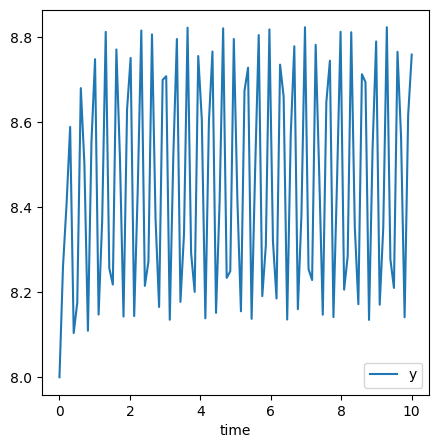

In [116]:
if False:
    WOLF_CTLSB = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_names=["at"], output_names=["s5"])
else:
    WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, 
                        input_names=["at_"], output_names=["s5"])
WOLF_BLDR = WOLF_CTLSB.makeSISOTransferFunctionBuilder(system_name="wolf_sys")
_ = plotSys(WOLF_BLDR.sys)

In [13]:
print(ctlsb.antimony)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

# Helpers

In [3]:
TIMES = np.linspace(0, 10, 100)

In [4]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1", "S2"], output_names=["S3"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

In [5]:
class PlotResult(object):
    def __init__(self, times = None, y_arr=None, ax=None):
        self.times = times
        self.y_arr = y_arr
        self.ax = ax
        
    def __repr__(self):
        return ""

In [6]:
# This class captures the results of a designing a closed loop system
class DesignResult(object):
    def __init__(self, grm=None, gnm=None, params=None, det=None, op_range=None):
        """
        Parameters
        ----------
        grm: control.TransferFunction
        gnm: control.TransferFunction
        params: lmfit.Parameters
        det: lmfit.MinimizerResult
        op_range: [float, float] - operating range for OLS
        
        """
        self.grm = grm
        self.gnm = gnm
        self.params = params
        self.det = det
        self.op_range = op_range
        
    def __repr__(self):
        return ""

## ``plotSys``

In [120]:
def plotSys(sys, times=None, initial_values=None, forced_input=None,
            title="", ax=None, output_labels=None, figsize=None,
            ylim=None, is_legend=True, is_plot=True):
    """
    Plots the system, either a NonlinearIOSystem or a TransferFunction.
    
    Parameters
    ----------
    sys: NonlinearIOSystem or TransferFunction
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float (default is step)
    figsize: (int, int)
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    title: str (plot title)
    is_legend: bool (include legend)
    
    Returns
    -------
    PlotResut
    """
    if "TransferFunction" in str(type(sys)):
        is_nonlinear = False
    else:
        is_nonlinear = True
    if times is None:
        times = TIMES
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(1, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if (initial_values is None) and is_nonlinear:
        initial_values = ctl.makeStateVector(sys)
    if figsize is None:
        figsize = (5, 5)
    if ax is None:
        _, ax = plt.subplots(1, figsize=figsize)
    if output_labels is None:
        if len(sys.output_labels) == 1:
            output_labels = ["y"]
        else:
            output_labels = list(sys.output_labels)
    # Simulate the system
    if is_nonlinear:
        t, y = control.input_output_response(sys, times, forced_input, initial_values)
    else:
        t, y = control.forced_response(sys, T=times, U=forced_input)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    if is_legend:
        ax.legend(output_labels)
    ax.set_xlabel("time")
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(ylim)
    if not is_plot:
        plt.close()
    return PlotResult(times=t, y_arr=y, ax=ax)
    
# Tests
times = T = np.linspace(0, 70, 500)
plot_result = plotSys(TEST_SYS, times, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr[0]))
#
numerator = 5
tf = control.TransferFunction([numerator], [1])
plot_result = plotSys(tf, times, forced_input=1, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr))
assert(plot_result.y_arr[0] == numerator)
print("OK!")

OK!


## ``makeCLTransferFunctions``

In [8]:
# grm: G_RM
# gnm: G_NM
# gf: Filter
# gc: Controller
# go: OLS
CLTransferFunctions = collections.namedtuple("CLTransferFunctions",
      "grm gnm gc gf go")
def makeCLTransferFunctions(gO_tf, params):
    """
    Makes two closed loop transfer functions.
        G_RM (s) - transfer function from the reference input to the measurement output
        G_NM (s) - transfer function from the noise input to the measurement output
    
    Parameters
    ----------
    gO_tf: control.TransferFunction (open loop transfer function)
    params:
        kP: float
        kI: float
        kF: float (a value <= 0 indicates there is no filter)
    
    Returns
    -------
    CLTransferFunctions
    """
    # Extract the parameters
    kP = params["kP"].value
    kI = params["kI"].value
    kF = params["kF"].value # a value of 0 indicates that there is no filter
    # Construct PI Controller
    gC_tf = control.TransferFunction([kP], [1]) + control.TransferFunction([kI], [1, 0])
    # Construct Filter
    if kF > 0:
        gF_tf = control.TransferFunction([kF], [1, kF])
    else:
        gF_tf = control.TransferFunction([1], [1])
    # RM Closed loop Transfer function
    gRM_tf = control.feedback(gC_tf*gO_tf, sys2=gF_tf)
    # NM Closed loop Transfer function
    gNM_tf = control.feedback(1, sys2=gC_tf*gO_tf*gF_tf)
    #
    return CLTransferFunctions(grm=gRM_tf, gnm=gNM_tf, gc=gC_tf, gf=gF_tf, go=gO_tf)
#
is_plot = False
tf = control.TransferFunction([1], [1, 1])
params = lmfit.Parameters()
params.add("kP", value=1)
params.add("kI", value=1)
params.add("kF", value=1)
cltf = makeCLTransferFunctions(tf, params)
assert(isinstance(cltf.grm, control.TransferFunction))
assert(isinstance(cltf.gnm, control.TransferFunction))
plot_response = plotSys(cltf.grm, is_plot=is_plot)
plot_response = plotSys(cltf.gnm, is_plot=is_plot)
print("OK!")

OK!


## ``designClosedLoop``

In [74]:
def designClosedLoop(open_loop_tf, is_filter=True, amp=1, times=TIMES, kmax=1e4):
    """
    Finds parameters for the closed loop system that eliminate noise and have a good step response.
    
    Paramters
    ---------
    open_loop_tf: control.TransferFunction (OLS transfer function)
    is_filter: bool (include the filter)
    amp: 0 <=float  (amplitude of the sine wave used to evaluate noise response)
    times: array-float
    kmax: float (maximum value of a constant)
    
    Returns
    -------
    DesignResult
    """
    NOISE_FREQ = 20*2*np.pi
    step_inputs = np.repeat(1, len(times))
    ideal_step_outputs = step_inputs
    noise_inputs = amp*np.sin(NOISE_FREQ*times) # Sinusoid input
    ideal_noise_outputs = np.repeat(0, len(times))
    def calculateDesignResiduals(params):
        """
        Calculates the residuals with an ideal step response.

        Parameters
        ----------
        params: lmfit.Parameters

        Returns
        -------
        array-float
        """
        cltf = makeCLTransferFunctions(open_loop_tf, params)
        gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
        # Calculate residuals for a step response
        _, step_est = control.forced_response(gRM_tf, T=times, U=1)
        step_residuals = ideal_step_outputs - step_est
        # Calculate residuals for a sinusoidal noise input
        _, sinusoid_est = control.forced_response(gNM_tf, T=times, U=noise_inputs)
        sinusoid_residuals = ideal_noise_outputs - sinusoid_est
        #
        return step_residuals + sinusoid_residuals
    #
    def calculateOperatingRange(params):
        """
        Calculates the operating range for the closed loop system designed with parameters
        
        Parameters
        ----------
        params: lmfit.Parameters
        
        Returns
        -------
        float, float
        """
        cltf = makeCLTransferFunctions(open_loop_tf, params)
        gRM_tf, gNM_tf, gC_tf = (cltf.grm, cltf.gnm, cltf.gc)
        #######
        # Step
        #######
        _, step_est = control.forced_response(gRM_tf, T=times, U=1)
        # Calculate input to controller
        ctl_inputs = step_inputs - step_est
        # Calculate controller output
        _, step_outputs = control.forced_response(gC_tf, T=times, U=ctl_inputs)
        #######
        # Noise
        #######
        # Calculate input to controller
        _, noise_est = control.forced_response(gRM_tf, T=times, U=noise_inputs)
        # Calculate input to controller
        ctl_inputs = noise_inputs - noise_est
        _, noise_outputs = control.forced_response(gC_tf, T=times, U=step_inputs)
        # Calculate operating range, the extreme values of inputs to the open loop system
        ols_inputs = np.append(step_outputs, noise_outputs)
        op_range = np.min(ols_inputs), np.max(ols_inputs)
        return op_range
    # 
    params = lmfit.Parameters()
    params.add("kP", value=1, min=0, max=kmax)
    params.add("kI", value=1, min=0, max=kmax)
    params.add("kF", value=1, min=0, max=kmax)
    minimizer_result = lmfit.minimize(calculateDesignResiduals, params)
    new_params = minimizer_result.params
    #
    cltf = makeCLTransferFunctions(gO_tf, new_params)
    gRM_tf, gNM_tf = (cltf.grm, cltf.gnm)
    op_range = calculateOperatingRange(new_params)
    design_result = DesignResult(grm=gRM_tf, gnm=gNM_tf, params=new_params, det=minimizer_result,
                                op_range=op_range)
    return design_result

# Tests
gO_tf = control.TransferFunction([1], [1, 1])
design_result = designClosedLoop(gO_tf, kmax=1e6, amp=10)
times = np.linspace(0, 10, 100)
noise_inputs = amp*np.sin(20*2*np.pi*times) # Sinusoid i
plotSys(design_result.gnm, times=times, ylim=[-1, 1],
                                          forced_input=noise_inputs, is_plot=False)
assert(isinstance(design_result.grm, control.TransferFunction))
assert(design_result.op_range[0] <= design_result.op_range[1])
print("OK!")

OK!


## ``plotDesignResult``

In [10]:
# Plots of the transfer functions
def plotDesignResult(design_result, ax=None, end_time=50, title="", is_plot=True, **kwargs):
    """
    Plots a DesignResult.
    
    Parameters
    ----------
    design_result: DesignResult
    ax: Matplotlib.Axes
    end_time: float
    is_plot: bool
    kwargs: dict (other plotting options)
    """
    if ax is None:
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (3, 3)
        _, ax = plt.subplots(1, figsize=figsize)
    times = np.linspace(0, end_time, 2000)
    plot_result1 = plotSys(design_result.grm, forced_input=1, times=times, ax=ax,
                         is_legend=False)
    plot_result2 = plotSys(design_result.gnm, forced_input=np.sin(5*times), times=times, 
            is_legend=False, ax=ax)
    if "ylim" in kwargs.keys():
        ylim = kwargs["ylim"]
    else:
        ylim = ax.set_ylim()
    xpos = end_time*1.1
    yspan = ylim[1] - ylim[0]
    ypos1 = ylim[1] - 0.1*yspan
    ypos2 = ypos1 - 0.2*yspan
    ax.text(xpos, ypos1, "G_RM", c="blue")
    ax.text(xpos, ypos2, "G_NM", c="orange")
    ax.set_ylim(ylim)
    ax.set_title(title)
    if not is_plot:
        plt.close()
 
# Tests
plotDesignResult(design_result, kmax=1, figsize= (2,2), is_plot=False, end_time=5)
print("OK!")

OK!


## ``plotStaircaseResponse``

In [24]:
def plotStaircaseResponse(builder, is_plot=True, **kwargs):
    """
    This function circumvents a bug in SISOTransferFunctionBuilder.plotStairCaseResponse.
    It has the same arguments and return value as the original function.
    """
    plot_result = builder.plotStaircaseResponse(is_plot=False, **kwargs)
    # Plot if requested
    if is_plot:
        times = np.array(plot_result.time_series.index)/1000
        df = pd.DataFrame(plot_result.time_series)
        df.index = times
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (10, 10)
        legends = list(df.columns)
        fig, ax = plt.subplots(1, figsize=figsize)
        staircase_column = [c for c in df.columns if "staircase" in c][0]
        staircase_values = df[staircase_column].values
        del df[staircase_column]
        ax.plot(df)
        ax2 = ax.twinx()
        # Plot the staircase
        ax2.plot(times, staircase_values, color="red",
              linestyle="--")
        ax2.set_ylabel(staircase_column, color="red")
        ax.legend(df.columns)
    #
    return plot_result

# TESTS
plot_response = plotStaircaseResponse(LINEAR_BLDR, initial_value=2, final_value=10, num_step=5, figsize=(3,3),
                                    legend_crd=(0.5, 1), end_time=100, is_plot=False)
assert(isinstance(plot_response.time_series, ctl.Timeseries))
print("OK!")

OK!


## ``makePIController``

In [108]:
def makePIController(kP=20, kI=10):
    """
    Makes a PI controller with control error as input
    
    Parameters
    ----------
    kP: float
    kI: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        return u[0]

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        output = kI*x[0] + kP*u[0]
        return output

    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
kP = 10
kI = 20
controller_sys = makePIController(kP=kP, kI=kI)
assert("NonlinearIOSystem" in str(type(controller_sys)))
plot_result = plotSys(controller_sys, forced_input=[1], is_plot=False)
data = plot_result.y_arr
assert(data[0] == kP)
assert(np.isclose(data[-1], kP + plot_result.times[-1]*kI))
print("OK")

OK


## ``makeFilter``

In [146]:
def makeFilter(system_name="filter_sys", kF=1):
    """
    Makes a filter.
    
    Parameters
    ----------
    system_name: str
    kF: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state, averaged signal)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        dy = kF*u[0] - kF*x[0]
        return dy

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return x[0]

    filter_sys = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name=system_name)
    return filter_sys

# Tests
kF = 1
filter_sys = makeFilter(kF=kF)
assert("NonlinearIOSystem" in str(type(filter_sys)))
plot_result = plotSys(filter_sys, forced_input=[1], times=np.linspace(0, 100, 1000), is_plot=False)
data = plot_result.y_arr
assert(np.abs(data[-1] - 1) < 0.01)
print("OK")

OK


## ``makeSinusoid``

In [176]:
def makeSinusoid(system_name="sinusoid_sys", amplitude=1, frequency=1):
    """
    Makes a sinusoidal signal, the only output.
    
    Parameters
    ----------
    system_name: str
    amplitude: float (amplitude of the sinusoid)
    frequency: float (frequencay of the sinusoid)
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return amplitude*np.sin(t*2*np.pi*frequency)

    sinusoid_sys = control.NonlinearIOSystem(
      None,
      outfcn,
      inputs=0,
      outputs=['out'],
      name=system_name)
    return sinusoid_sys

# Tests
sinusoid_sys = makeSinusoid()
assert("NonlinearIOSystem" in str(type(sinusoid_sys)))
plot_result = plotSys(sinusoid_sys, forced_input=1, times=np.linspace(0, 10, 1000), is_plot=False)
count = len([v for v in plot_result.y_arr[0] if v >= 0.999])
assert(count > 1)
print("OK")

OK


## ``makeAdder``

In [110]:
def makeAdder(input_names, output_name="out", system_name="adder_sys"):
    """
    Creates a NonlinearIOSystem that does addition
    of the inputs. Any name that begins wit a "-" is subtracted.
    
    Parameters
    ----------
    input_nmames: list-str
    output_name: str
    system_name: str
    
    Returns
    -------
    NonlinearIOSystem
    """
    adjustments = []
    adjusted_input_names = []
    def outfcn(_, __, u, ___):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return adjustments.dot(u)
    #
    for name in input_names:
        if name[0] == "-":
            value = -1
            new_name = name[1:]
        else:
            value = 1
            new_name = name
        adjustments.append(value)
        adjusted_input_names.append(new_name)
    adjustments = np.array(adjustments)
    #
    return control.NonlinearIOSystem(
          None,
          outfcn,
          inputs=adjusted_input_names,
          outputs=output_name, name=system_name)

# Tests
adder_sys = makeAdder(["a", "-b", "c"])
assert("NonlinearIOSystem" in str(type(adder_sys)))
# Simulate to verify 
plot_result = plotSys(adder_sys, forced_input=[3, 2, 4], is_plot=False)
data = plot_result.y_arr
assert(np.var(data[0]) == 0)
assert(data[0][0] == 5)
print("OK")

OK


## ``makeClosedLoopSystem``

OK!


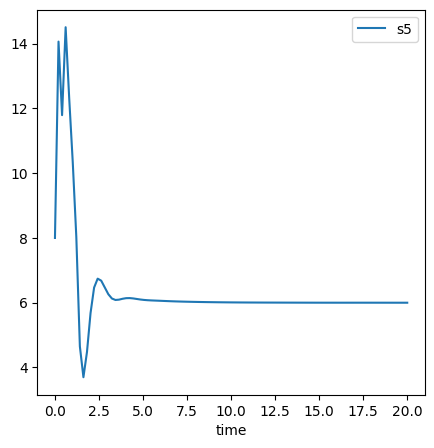

In [178]:
def makeClosedLoopSystem(ctlsb, kP=1, kI=1, kF=1, noise_amplitude=1, noise_frequency=20):
    """
    Create a closed loop system with a controller and filter for an SBML model.
    
    Parameters
    ----------
    ctlsb: ControlSBML (for open loop system)
    kP: float
    kI: float
    kF: float
    noise_amplitude: float
    noise_frequency: float
    
    Returns
    -------
    Interconnect
    """
    # Information for open loop system
    if len(ctlsb.input_names) != 1:
        raise ValueError("Open loop system should have exactly 1 input")
    if len(ctlsb.output_names) != 1:
        raise ValueError("Open loop system should have exactly 1 output")
    open_sys = ctlsb.makeNonlinearIOSystem("open_sys")
    sinusoid_sys = makeSinusoid(system_name="sinusoid_sys",
                                amplitude=noise_amplitude, frequency=noise_frequency)
    open_input = "open_sys.%s" % ctlsb.input_names[0]
    open_output = "open_sys.%s" % ctlsb.output_names[0]
    # Other elements
    filter_sys = makeFilter(kF=kF)
    controller_sys = makePIController(kP=kP, kI=kI)
    differ_sys = makeAdder(["setpoint", "-measurement"], system_name="differ_sys")
    adder_sys = makeAdder(["noise", "open_sys"], system_name="adder_sys")
    closed_sys = control.interconnect(
      [adder_sys, sinusoid_sys, open_sys, controller_sys, differ_sys, filter_sys],       # systems
      connections=[
        ['adder_sys.noise', "sinusoid_sys.out"],
        ['adder_sys.open_sys', open_output],
        ['filter_sys.in', "adder_sys.out"],
        ['differ_sys.measurement', 'filter_sys.out'],
        [open_input, 'controller_sys.out'],
        ['controller_sys.in',  'differ_sys.out'],
      ],
      inplist=["differ_sys.setpoint"],
      outlist=[open_output],
    )
    return closed_sys

# Tests
setpoint = 6
new_closed_sys = makeClosedLoopSystem(WOLF_CTLSB, kP=20, kI=10)
assert("Interconnect" in str(type(new_closed_sys)))
plot_result = plotSys(new_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), 
                      is_plot=False,
                      output_labels=["s5"])
data = plot_result.y_arr
assert(data[0] == 8)
assert(np.abs(setpoint - data[-1]) < 0.2)
print("OK!")

# Step 1. Problem Statement

## Problem Statement
The Wolf model describes glycolysis in a region in which many of the metabolites have oscillating concentrations.
We want to increase the production of pyruvate and eliminate oscillations.

## System studied
A system is specified by its input and output.
The input to our system is ATP (``at_``). The output is pyruvate (``s5``).
The open loop response is shown below.

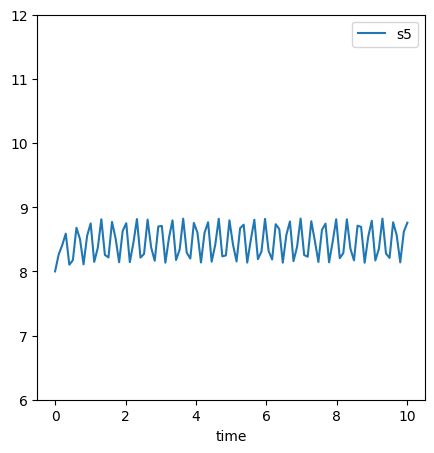

In [32]:
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, 
                        input_names=["at_"], output_names=["s5"])
wolf_sys = WOLF_CTLSB.makeNonlinearIOSystem("wolf_sys")
plotSys(wolf_sys, output_labels=["s5"], ylim=[6, 12])

## Control objectives
1. Eliminate the oscillations in pyruvate.
1. Control pyruvate to 6 units.

## Controllability and operating region
We find a range of ATP values of ATP that control pyruvate.

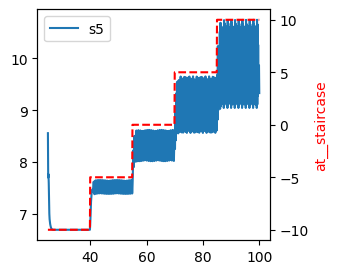

In [33]:
WOLF_BLDR = WOLF_CTLSB.makeSISOTransferFunctionBuilder(system_name="wolf_sys")
plotStaircaseResponse(WOLF_BLDR, initial_value=-10, final_value=10, num_step=5, figsize=(3,3),
                                    legend_crd=(0.5, 1), start_time=25, end_time=100,
                     ylim=[6, 12])

The above plot indicates by adding (or removing) ATP over the operating range $[-10, 10]$, we can control pyruvate in the range 6.5 to approximately 12.

# Step 2. System Identification

Here, we estimate a transfer function for the system over the operating range.

## Estimated transfer function

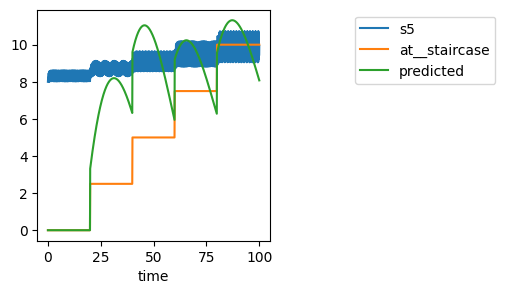

In [37]:
fitter_result = WOLF_BLDR.fitTransferFunction(3, 3, 
                                                   final_value=10,
                                                   initial_value=0,
                                                   start_time=0, end_time=100)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

In [40]:
WOLF_TRANSFER_FUNCTION = fitter_result.transfer_function
WOLF_TRANSFER_FUNCTION

TransferFunction(array([0.64412809, 0.22299594, 0.00225172]), array([0.49145211, 0.03429846, 0.00454916]))

## Evaluation of the quality of the estimated transfer function

Although the predicted s5 (pyruvate) do not closely match those of the model, the trend in the predictions is consistent with the model. We see that the DC Gain is approximately 0.5.

# Step 3. Optimization-Based Control Design

This step designs a closed loop system that achieves our control objectives
and handles noise well. Noise is specified by a high frequency sinewave, 20 Hz.

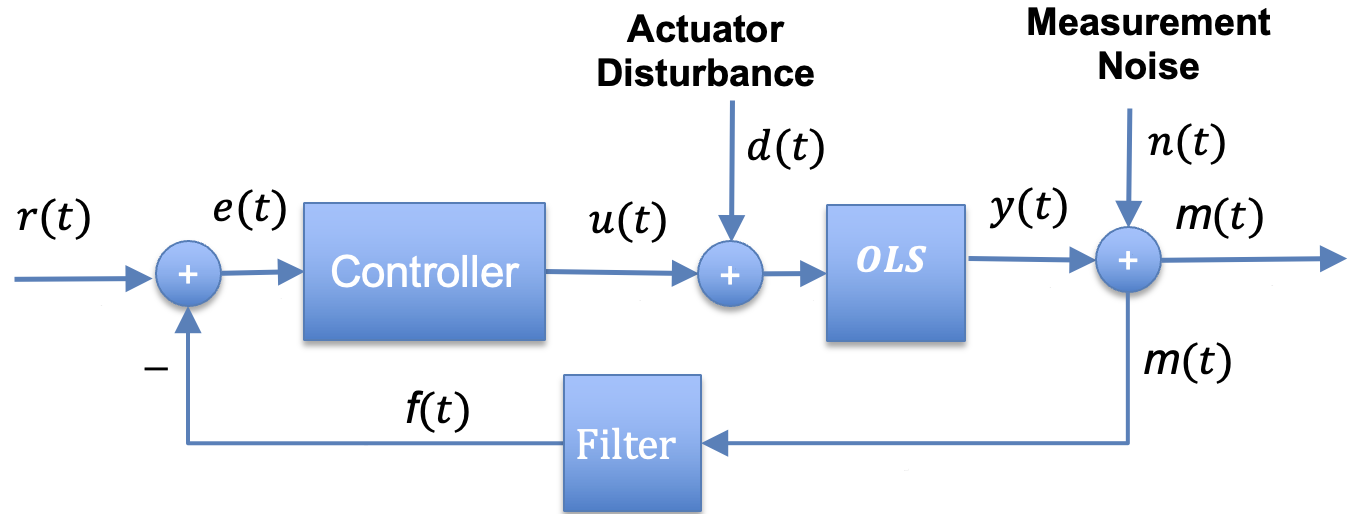

In [14]:
Image("closed_loop_system.png", width = 400, height = 200)

It seems that with this system we are abole to obtain the desired
$G_{RM}(s)$ step response, but we cannot eliminate the sinusoid noise
response for $G_{NM} (s)$.
It is important to not let design constants become to large since the
system becomes unstable.
A lower value of ``amp`` seems to result in a better design, although the design
parameters are large (e.g., $k_I, k_F \approx 100$.
Changing the balance between step and sinusoidal responses (e.g., the value of ``amp``)
doesn't seem to benefit the design. We end up with the same design parameters.

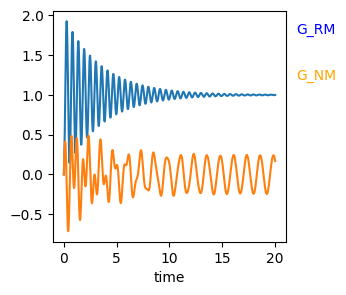

In [93]:
# Low amp
times = np.linspace(0, 20, 200)
design_result = designClosedLoop(WOLF_TRANSFER_FUNCTION, kmax=130, amp=0.01, times=times)
plotDesignResult(design_result, end_time=max(times))

In [88]:
design_result.params

name,value,standard error,relative error,initial value,min,max,vary
kP,0.76269300,0.02249504,(2.95%),1,0.00000000,100.000000,True
kI,100.0000000,5.99318417,(5.99%),1,0.00000000,100.000000,True
kF,99.9927812,3156.25989,(3156.49%),1,0.00000000,100.000000,True


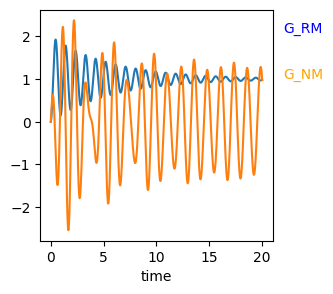

In [102]:
# High amp
times = np.linspace(0, 20, 200)
design_result = designClosedLoop(WOLF_TRANSFER_FUNCTION, kmax=45, amp=10, times=times)
plotDesignResult(design_result, end_time=max(times))

In [89]:
design_result.params

name,value,standard error,relative error,initial value,min,max,vary
kP,0.76269300,0.02249504,(2.95%),1,0.00000000,100.000000,True
kI,100.0000000,5.99318417,(5.99%),1,0.00000000,100.000000,True
kF,99.9927812,3156.25989,(3156.49%),1,0.00000000,100.000000,True


The operating range seems large, but it's worthwile exploring.

In [103]:
design_result.op_range

(-0.4956993604462353, 900.7597344490073)

# Step 4. Testbed evaluations

The testbed evaluations should check the step response and the noise response.
Here, we just check the step response.

## Implementation

We make use of the helper ``makeClosedLoopSystem``. Some modification to the function are required to also check for sinusoidal noise.

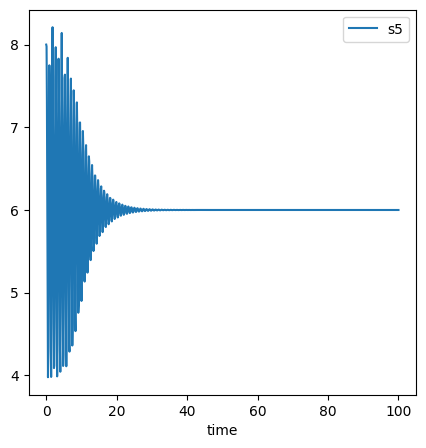

In [151]:
setpoint = 6
new_closed_sys = makeClosedLoopSystem(WOLF_CTLSB, kP=0.76, kI=100, kF=100)
assert("Interconnect" in str(type(new_closed_sys)))
times = np.linspace(0, 100, 1000)
plot_result = plotSys(new_closed_sys, forced_input=[setpoint], times=times, 
                      is_plot=True,
                      output_labels=["s5"])

## Tuning

# Step 5. Discussion

1. Operating range
1. How well are control objectives achieved
1. Value provided by control design